# Image Stitching for Panormaic Photos

Steps to Take:

* Detect keypoints and extract features from each of the input images using a feature detection algorithm like SIFT, SURF or ORB.

* Match the keypoints between the images using a feature matching algorithm like Brute-Force matching or FLANN matching.

* Use the matched keypoints to estimate the homography matrix between each image and the reference image.

* Apply the estimated homography matrices to align the images and blend them together to form a panoramic image.

* Crop the resulting panoramic image to remove any black borders.

## Getting Setup

In [1]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

In [2]:
!wget https://upload.wikimedia.org/wikipedia/commons/b/b6/122_-_Toronto_-_Septembre_2009.jpg

--2023-02-07 19:50:27--  https://upload.wikimedia.org/wikipedia/commons/b/b6/122_-_Toronto_-_Septembre_2009.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33276674 (32M) [image/jpeg]
Saving to: ‘122_-_Toronto_-_Septembre_2009.jpg’

122_-_Toronto_-_Sep 100%[===================>]  31.73M  24.4MB/s    in 1.3s    

2023-02-07 19:50:29 (24.4 MB/s) - ‘122_-_Toronto_-_Septembre_2009.jpg’ saved [33276674/33276674]



In [3]:
# Split the Test image into two overlapping portions
img0 = cv2.imread('122_-_Toronto_-_Septembre_2009.jpg')
img0 = cv2.resize(img0, (600, 200))

h = img0.shape[0]
w = img0.shape[1]
img0.shape, h, w

((200, 600, 3), 200, 600)

(200, 360)


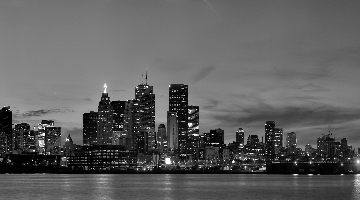

In [4]:
# Right Image
img_ = img0[:, int(w*0.4):]
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
print(img1.shape)
cv2_imshow(img1)

(200, 360)


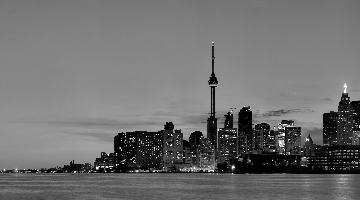

In [5]:
# Left Image
img = img0[:, :int(w*0.6)]
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img2.shape)
cv2_imshow(img2)

In [6]:
# Perform SIFT feature detection and descriptors
sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(img1, None)
kp1, des1 = sift.detectAndCompute(img2, None)

# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

# Find all the good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)

# Use the matches to estimate the homography matrix
src_pts = np.float32([kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
mask_matches = mask.ravel().tolist()

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, H)

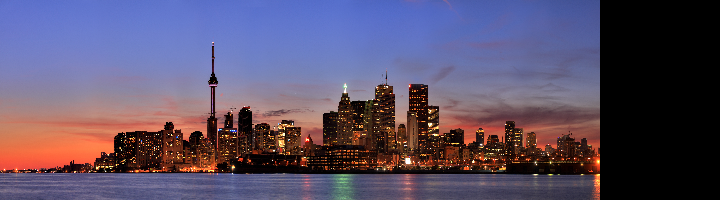

In [7]:
dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img
cv2_imshow(dst)